# Práctica 3: Vecinos próximos y k-means
## Autores: Alejandro Benimeli Miranda y Rodrigo Juez Hernández

In [1]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.cluster
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

#our implementation
from Datos import Datos
import EstrategiaParticionado
from ClasificadorRegresionLogistica import *
from ClasificadorNaiveBayes import *
from ClasificadorKNN import *


str_mean = "{:.4f} ± {:.4f}"
tag_propia = "Propia"
tag_sklearn = "Sklearn"
regexrule_filename = "../.*?/(.*?).data"

dataset1 = '../ConjuntosDatosP2Knn/wdbc.data'
dataset2 = '../ConjuntosDatosP2Knn/pima-indians-diabetes.data'

# Ejecución Código

## Logistic Regression Scores

In [2]:
def create_table(learning_rates, epochs, tag1, tag2):
    y = range(0, 10)
    def generate_multiindex(first_level, second_level):
        y = [(i, j) for i in first_level for j in second_level]
        return y


    y = generate_multiindex(learning_rates, epochs)
    namesy = ["learn_rate", "n_epochs"]

    x = [(tag1, tag_propia),     (tag1, tag_sklearn),     (tag2, tag_propia),     (tag2, tag_sklearn)]
    namesx = ["dataset", "func"]


    return pd.DataFrame(index=pd.MultiIndex.from_tuples(y, names = namesy), columns=pd.MultiIndex.from_tuples(x, names = namesx), dtype=float)


def compare_implementation_cross(learning_rate, n_epochs, cv, dataset_filename):
    dataset = Datos(dataset_filename)
    
    data_sklearn = dataset.datos
  
    X = data_sklearn.loc[:, dataset.datos.columns != "Class"].to_numpy()
    y = data_sklearn["Class"].to_numpy()
    
    precisiones = cross_val_score(SGDClassifier(max_iter = n_epochs, learning_rate = "constant", eta0 = learning_rate), X, y, cv=cv)
    skmean = 1 - np.mean(precisiones)
    skstd = np.std(precisiones)

    estrategia = EstrategiaParticionado.ValidacionCruzada(cv)
    clasificador = ClasificadorRegresionLogistica(learn_rate=learning_rate, n_epocas=n_epochs)
    mean, std = clasificador.validacion(estrategia,dataset,clasificador)

    return str_mean.format(skmean, skstd), str_mean.format(mean, std)

def final_table(cv = 5, learning_rates = [0.5, 0.8, 1], epochs = [100, 150, 200], filename1 = dataset1, filename2 = dataset2, debug = True):
    tag1, tag2 = re.findall(regexrule_filename, filename1)[0], re.findall(regexrule_filename, filename2)[0]
    dataframe = create_table(learning_rates, epochs, tag1, tag2)
    
    for filename,tag in zip([filename1, filename2],[tag1, tag2]):
        None if debug == False else print(filename, ":")
        for learning_rate in learning_rates:
            None if debug == False else print("\tlearning_rate: ", learning_rate)
            for epoch in epochs:
                None if debug == False else print("\t\tepoch: ", epoch)
                skres, ownres = compare_implementation_cross(learning_rate, epoch, cv, filename)
                dataframe.loc[(learning_rate, epoch), (tag, tag_propia)] = ownres
                dataframe.loc[(learning_rate, epoch), (tag, tag_sklearn)] = skres

    return dataframe

## Confusion Matrix

In [3]:
TP = ("Predicha", "1"), ("Real", "1")
FP = ("Predicha", "1"), ("Real", "0")
FN = ("Predicha", "0"), ("Real", "1")
TN = ("Predicha", "0"), ("Real", "0")

def generate_confusion_matrix(cv, dataset_filename, clasificador):
    x = [("Real", "1"),
         ("Real", "0")]
    y = [("Predicha", "1"),
         ("Predicha", "0")]

    row_list = pd.MultiIndex.from_tuples(y)
    col_list = pd.MultiIndex.from_tuples(x)
    confusion_matrix = pd.DataFrame(index=row_list, columns=col_list, dtype=int)
    
    confusion_matrix.loc[TP] = 0
    confusion_matrix.loc[FP] = 0
    confusion_matrix.loc[FN] = 0
    confusion_matrix.loc[TN] = 0


    dataset=Datos(dataset_filename)
    estrategia=EstrategiaParticionado.ValidacionCruzada(cv)

    valores_reales = []
    predicciones = []
    particiones = estrategia.creaParticiones(dataset)
    for part in particiones:
        datosTrain = dataset.extraeDatos(part.indicesTrain)
        datosTest = dataset.extraeDatos(part.indicesTest)

        clasificador.entrenamiento(datosTrain, dataset.nominalAtributos, dataset.diccionario)
        valores_reales.extend(datosTest["Class"].tolist())
        predicciones.extend(clasificador.clasifica(datosTest, dataset.nominalAtributos, dataset.diccionario))

    for pred, real in zip(predicciones, valores_reales):
        confusion_matrix.loc[("Predicha", str(int(pred))), ("Real", str(int(real)))] += 1

    return confusion_matrix



## ROC Space

In [15]:
def generate_roc_space(cv, dataset_filename, knn, nb, reglog):

    x = []
    y = []
    
    clasificadores = [knn, nb, reglog]
    for clasificador in clasificadores:
        matrix = generate_confusion_matrix(cv, dataset_filename, clasificador)

        # FPR
        x.append(matrix.loc[FP] / (matrix.loc[FP] + matrix.loc[TN]))
 
        # TPR
        y.append(matrix.loc[TP] / (matrix.loc[TP] + matrix.loc[FN]))

    fig, ax = plt.subplots()
    
    # TODO: hacerlo mas modular? no asumir que los clasificadores vienen en ese orden
    knn = plt.scatter(x[0], y[0], marker='o', color='r')
    nb = plt.scatter(x[1], y[1], marker='o', color='g')
    lr = plt.scatter(x[2], y[2], marker='o', color='b')

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot([0, 1], [0, 1], 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(f"Espacio ROC {re.findall(regexrule_filename, dataset_filename)[0]}")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend((knn, nb, lr),
               ('KNN', 'Naive Bayes', 'Regresion Logistica'),
               scatterpoints=1,
               loc='lower right',
               ncol=1,
               fontsize=8)
    

## ROC Curve

In [12]:
def generate_roc_curve(cv, dataset_filename, learn_rate, epochs):
    dataset=Datos(dataset_filename)
    estrategia=EstrategiaParticionado.ValidacionCruzada(cv)
    clasificador=ClasificadorRegresionLogistica(learn_rate, epochs)

    valores_reales = []
    scores = []
    particiones = estrategia.creaParticiones(dataset)
    for part in particiones:
        datosTrain = dataset.extraeDatos(part.indicesTrain)
        datosTest = dataset.extraeDatos(part.indicesTest)

        clasificador.entrenamiento(datosTrain, dataset.nominalAtributos, dataset.diccionario)
        valores_reales.extend(datosTest["Class"].tolist())
        scores.extend(clasificador.confidence(datosTest))
    
    P = valores_reales.count(1)
    N = valores_reales.count(0)
    tp = 0
    fp = 0
    y_tp = 0
    x_fp = 0
    tmp = zip(valores_reales, scores)
    x = []
    y = []
    for inst in sorted(tmp, key=lambda x: x[1], reverse=True):
        if inst[0] == 1:
            tp += 1
            y_tp = tp/P
        else:
            fp += 1
            x_fp = fp/N
        x.append(x_fp)
        y.append(y_tp)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y)

    ax.plot([0, 1], [0, 1], 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(f"Curva ROC Regresion {re.findall(regexrule_filename, dataset_filename)[0]}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")


# <font color='purple'>Memoria</font>
Como hay que comparar la implementación propia con la de sklearn y ver varios learning_rates y numero de iteraciones decidimos hacer una tabla conjunta de donde extraer los datos a estudiar, y posicionarla entre el apartado 1 y 2 para que sea comoda de ver en ambos apartados

## Apartado 1
#### Implementación Propia
A la hora de entrenar utilizamos una técnica que nos permite obtener mejores resultados de una forma más consistente. Dicha técnica consiste en reorganizar los datapoints de la entrada para que alternen entre la clase positiva y la negativa. Como ya sabemos, el orden en el que se procesan los datapoints afecta a la frontera final, por lo que si hay muchos datos de una misma clase seguidos, es posible que la frontera se mueva mucho en una dirección y distorsione la frontera final. En cambio, si balanceamos los puntos en función de la clase, la frontera se moverá de una forma más controlada y dará unos resultados más consistentes (y en general mejores).

#### Resultados
El dataset wdbc funciona mucho mejor para la regresión lineal, asumimos que esto es porque pima-indians-diabetes no es linealmente separable, ya que para otros clasificadores como KNN o NaiveBayes, da mejores resultados (se verá en el espacio ROC en el apartado 3).

Respecto a la variación del learning rate y el número de iteraciones podemos ver como los mejores resultados en wdbc dan con el learn_rate 0.25 y 0.75, para todas las pruebas de iteraciones. Y en cuanto a las iteraciones vemos que cuando el learning rate es muy pequeño (0.25) es mejor tener muchas, mientras que según vamos aumentando varia más, por ejemplo con learning_rate de 1 las 150 iteraciones tienen el peor resultado, esto debe ser debido a que hay mucho cambio entre epoch y epoch y se pasa cada vez que hace una actualización, por lo que va a hacer movimientos bruscos por la zona que tiene que estar pero el resultado final va a ser un poco aleatorio. 

El mejor resultado para wdbc es es learning_rate 0.25 con 150 iteraciones o learning_rate 0.75 con 100 iteraciones.

En pima-indians-diabetes no varia tanto entre pruebas, el más estable es el learning rate de 0.25 ya que todas las iteraciones estan por debajo de 0.36 y la mejor es 0.3464 que es la mejor de todas las pruebas. Esta prueba esta hecha con 100 iteraciones. Sospechamos que no varía tanto ya que como no es linealmente separable un número alto de iteraciones o un learning rate bajo no puede solucionar el problema.

In [6]:
final_table(learning_rates = np.arange(0.0, 1.1, 0.25)[1:], epochs = range(50, 151, 50), debug = False)

dataset                         wdbc                  pima-indians-diabetes  \
func                          Propia          Sklearn                Propia   
learn_rate n_epochs                                                           
0.25       50        0.1671 ± 0.0585  0.1107 ± 0.0327       0.3529 ± 0.0236   
           100       0.1073 ± 0.0259  0.0985 ± 0.0206       0.3464 ± 0.0237   
           150       0.0878 ± 0.0259  0.1054 ± 0.0384       0.3581 ± 0.0187   
0.50       50        0.0932 ± 0.0316  0.1266 ± 0.0443       0.3594 ± 0.0357   
           100       0.0949 ± 0.0305  0.1476 ± 0.1067       0.3841 ± 0.0496   
           150       0.1125 ± 0.0365  0.1564 ± 0.0866       0.3605 ± 0.0532   
0.75       50        0.1141 ± 0.0516  0.2704 ± 0.1676       0.3960 ± 0.0956   
           100       0.0879 ± 0.0184  0.1617 ± 0.0530       0.3489 ± 0.0354   
           150       0.0914 ± 0.0121  0.0914 ± 0.0069       0.3502 ± 0.0155   
1.00       50        0.1144 ± 0.0592  0.1072 ± 0.0274       0.3660 ± 0.0386   
           100       0.0914 ± 0.0133  0.1971 ± 0.0877       0.3620 ± 0.0537   
           150       0.1265 ± 0.0468  0.1986 ± 0.0402       0.3489 ± 0.0193   

dataset                               
func                         Sklearn  
learn_rate n_epochs                   
0.25       50        0.4246 ± 0.0950  
           100       0.4884 ± 0.1363  
           150       0.4361 ± 0.1185  
0.50       50        0.4245 ± 0.0378  
           100       0.3905 ± 0.0591  
           150       0.4469 ± 0.0968  
0.75       50        0.4287 ± 0.1212  
           100       0.5286 ± 0.1035  
           150       0.4530 ± 0.1177  
1.00       50        0.4623 ± 0.1447  
           100       0.4727 ± 0.1487  
           150       0.4440 ± 0.0748

## Apartado 2
#### Implementación en sklearn
La comparación se hizo con SGDClassifier, ya que sklearn.LogisticRegression no tiene learning rate ni muchos parametros que necesitamos para comparar con nuestra implementación.

Además LogisticRegression minimiza la probabilidad log, mientras que SGDClassifier usa Stochastic Gradient Descent. Este último se parece mucho más a nuestra implementación. Tanto nuestra implementación como SGDClassifier actualizan los pesos por cada ejemplo, sin embargo SGD hace aproximaciones para ser mucho más rápido.

#### Argumentos SGDClassifier:
* _max_iter_: es el número máximo de iteraciones que va a realizar, en este caso es un límite, en nuestra implementación es el número de iteraciones exactas.
* _learning\_rate_: La manera de actualizar los pesos, el que más se parece a nuestra implementación es "constant" asi que es el que usaremos. Los otros modos usan eurísticas que van actualizando el learning rate durante el proceso.
* _eta0_: Learning rate inicial, como queremos hacer que la implementación de sklearn se parezca a la nuestra usamos learning_rate "constant" y el eta0 ya no es el inicial si no el learning rate que se usa durante todo el proceso.
* _early_stopping_: Booleano que determina si se para de entrenar cuando la score de validación no aumenta. Para determinar esto el fitter separa una pequeña porción de los datos stratificados y va comprobando el score con esos. Nosotros lo hemos dejado a False ya que en nuestra implementación no lo usamos.
* _n\_iter_no_change_: Cuantas epochs sin mejoría pasan hasta que para el entrenamiento, dependiendo de "_early\_stopping_" esa comprobación se hace con el conjunto de ese parametro o con el conjunto de entrenamiento completo.

#### Argumentos LogisticRegression:
* _solver_: los "solvers" son algoritmos de opimización. Por defecto vine "lbfgs".
* _max_iter_: Igual que en SGDC

#### Comentario y comparación
De nuevo podemos observar como pima-indians-diabetes tiene un error muy alto en comparación a wdbc. Por lo general varía mucho más en sklearn respecto a la implementación propia y el error suele ser más alto. Esto puede ser a la manera en que ordenamos los datos en la implementación propia (explicado en el apartado 1) o la inicialización aleatoria del vector inicial.

En wdbc de nuevo podemos observar como 0.25 es el mejor learning_rate, solo que en este caso la cantidad óptima de iteraciones es 100. El learning rate 0.5 tiene resultados bastante malos comparados con nuestra implementación al igual que 0.75, con una excepción, 150 iteraciones tiene el mismo error, sin embargo 100 y 50 es mucho peor. Donde mejora sklearn es con learning rate de 1 y 50 iteraciones, sin embargo podemos ver que con 100 y 150 el resultado vuelve a empeorar demasiado.

Podemos observar un comportamiento similar en pima-indians-diabetes, es bastante peor que nuestra implementación siendo 0.5 y 100 la mejor prueba.

## Apartado 3

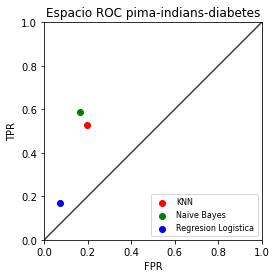

In [16]:
generate_roc_space(5, '../ConjuntosDatosP2Knn/pima-indians-diabetes.data', ClasificadorKNN(5), ClasificadorNaiveBayes(True), ClasificadorRegresionLogistica(0.1, 100))

Lo primero que observamos es que la regresión lineal rinde peor que tanto KNN como Naive Bayes, que tienen un rendimiento similar. Esto era de esperar, pues como ya comentamos más arriba, parece que este dataset no se separa bien linealmente.

Observamos que aunque la regresión lineal tiene una false positive rate (FPR) ligeramente inferior que los otros dos (es decir, clasifica datos como clase positiva de forma errónea menos veces), pero también tiene una TPR mucho más baja que los otros dos (es decir, clasifica datos como clase positiva correctamente muy pocas veces). Es tan baja que es prácticamente igual que la FPR, lo que pone a este punto muy cercano a la recta en la que caería un clasificador que clasifica aleatoriamente. Cabe destacar que aunque KNN y Naive Bayes rinden mejor que la regresión lineal, tampoco se obtienen unos resultados muy buenos con este dataset.

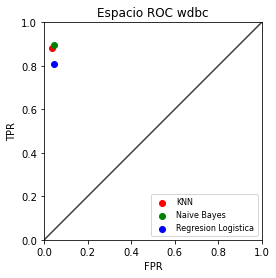

In [17]:
generate_roc_space(5, '../ConjuntosDatosP2Knn/wdbc.data', ClasificadorKNN(5), ClasificadorNaiveBayes(True), ClasificadorRegresionLogistica(0.1, 100))

En general, vemos que los tres clasificadores rinden de una forma muy similar con el dataset wdbc. Tienen una true positive rate (TPR) muy alta y una false positive rate (FPR) muy baja. Están todos muy cerca del punto (0, 1), que es el que correspondría a un clasificador perfecto (que no comete ningún error de clasificación). De los tres se ve que Naive Bayes rinde marginalmente mejor que los otros dos, pero la diferencia es tan pequeña que es despreciable.

## Apartado 4

Las curvas ROC (Receiver Operating Characteristic Curve) permiten visualizar de una forma muy gráfica y sencilla la capacidad de un clasificador binario de discernir entre puntos de clase positiva y negativa mientras se va variando el umbral que decide de qué clase es un punto. En general, muestra la TPR contra la FPR para diferentes valores del umbral.

La forma de calcular la gráfica variando el umbral es computacionalmente muy costosa, ya que hay que clasificar todos los puntos varias veces. Por ello, nosotros usamos un método que nos permite calcular una curva aproximada clasificando cada punto una sola vez, calculando los scores de todos ellos, ordenandolos de mayor a menor y dibujando una función escalonada, ascendiendo cuando el punto es de clase positiva y moviendose a la derecha cuando es de clase negativa.

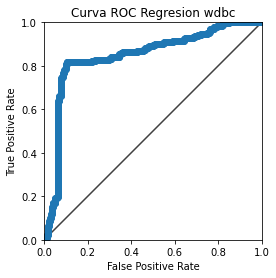

In [13]:
generate_roc_curve(5, '../ConjuntosDatosP2Knn/wdbc.data', 0.1, 250)

Para este dataset vemos que la curva se aleja mucho de la recta de un clasificador aleatorio por la izquierda, por lo que el área bajo la curva es muy grande. Hablamos sobre el área debajo de la curva ROC porque esta es la probabilidad de que el clasificador sea capaza de clasificar a dos individuos, uno de clase positiva y el otro de clase negativa, de forma correcta.



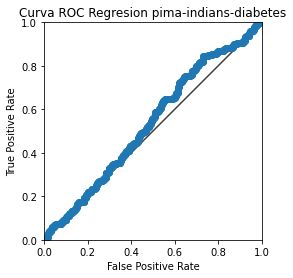

In [14]:
generate_roc_curve(5, '../ConjuntosDatosP2Knn/pima-indians-diabetes.data', 0.1, 250)

Comentario Espacio ROC Pima Indians:
En pima-indians, la curva ROC está ligeramente por encima de la recta que representaría un clasificador aleatorio. Esto concuerda con lo visto en otros apartados, ya que con este dataset da unos resultados muy malos, sin bajar el error de un 0.35.